# Training

# Import packages

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
import ast

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint

from chemprop import data, featurizers, models, nn
from chemprop.utils import make_mol

# Change data inputs here

In [2]:
chemprop_dir = Path.cwd().parent
input_path = chemprop_dir / "tests" / "data" / "atomic_regression_atom_mapped_input_copy.csv" # path to your data .csv file
num_workers = 0 # number of workers for dataloader. 0 means using main process for data loading
smiles_column = 'smiles' # name of the column containing SMILES strings
target_columns = ['charges', 'charges2'] # list of names of the columns containing targets

## Load data

In [3]:
df_input = pd.read_csv(input_path)
df_input

,smiles,charges,charges2
0,[S:1]1[S:2][C:3]2([C:23]([H:41])([H:42])[H:43]...,"[-0.093451, -0.121894, 0.159898, -0.198989, 0....","[-0.093451, -0.121894, 0.159898, -0.198989, 0...."
1,[Cl:1][c:2]1[c:3]([C:9]([n:10]2[c:11](=[O:12])...,"[-0.072057, 0.128813, -0.014234, -0.095166, -0...","[-0.072057, 0.128813, -0.014234, -0.095166, -0..."
2,[C:1]([C:2](=[O:3])[N:4]1[C:5]([H:21])([H:22])...,"[-0.47105, 0.575086, -0.557499, -0.171529, -0....","[-0.47105, 0.575086, -0.557499, -0.171529, -0...."
3,[C:1]([N:2]([C:3]([H:21])([H:22])[H:23])[c:4]1...,"[-0.220661, -0.131327, -0.220029, 0.338192, -0...","[-0.220661, -0.131327, -0.220029, 0.338192, -0..."
4,[C:1]([N:2]([C:3]([C:4]([C:5]([H:30])([H:31])[...,"[-0.206838, -0.184143, -0.07144, 0.180829, -0....","[-0.206838, -0.184143, -0.07144, 0.180829, -0...."
...,...,...,...
495,[C:1]([c:2]1[n:3][c:4]([N:5]([C:6]([H:29])([H:...,"[-0.399796, 0.334556, -0.490008, 0.462631, -0....","[-0.399796, 0.334556, -0.490008, 0.462631, -0...."
496,[Cl:1][C:2]1([H:17])[C:3]([O:13][C:14]([C:15](...,"[-0.194226, -0.004708, 0.142631, -0.170452, 0....","[-0.194226, -0.004708, 0.142631, -0.170452, 0...."
497,[S:1]=[C:2]([N:3]1[C:4]([H:21])([H:22])[C:5]([...,"[-0.519424, 0.238167, -0.04533, -0.064195, 0.0...","[-0.519424, 0.238167, -0.04533, -0.064195, 0.0..."
498,[C:1]([C:2]([C:3]([H:24])([H:25])[H:26])([C:4]...,"[-0.3687, 0.12996, -0.366706, -0.152338, -0.19...","[-0.3687, 0.12996, -0.366706, -0.152338, -0.19..."


## Get SMILES and targets

In [4]:
smis = df_input.loc[:, smiles_column].values
ys = df_input.loc[:, target_columns]

In [5]:
smis[:2] # show first 2 SMILES strings

array(['[S:1]1[S:2][C:3]2([C:23]([H:41])([H:42])[H:43])[N:4]([C:20]([C:21]([C:22]([H:38])([H:39])[H:40])([H:36])[H:37])([H:34])[H:35])[C:5](=[O:6])[C:7]13[N:8]([c:9]1[c:10]([c:11]([H:24])[c:12]([H:25])[c:13]([H:26])[c:14]1[H:27])[C:15]3([C:16]([H:28])([H:29])[H:30])[C:17]([H:31])([H:32])[H:33])[C:18]2=[O:19]',
       '[Cl:1][c:2]1[c:3]([C:9]([n:10]2[c:11](=[O:12])[c:13]([N+:14]([O-:15])=[O:16])[c:17]([H:25])[c:18]([H:26])[c:19]2[H:27])([H:23])[H:24])[c:4]([H:20])[c:5]([H:21])[c:6]([F:7])[c:8]1[H:22]'],
      dtype=object)

In [6]:
ys[:5] # show first 5 molecule targets

,charges,charges2
0,"[-0.093451, -0.121894, 0.159898, -0.198989, 0....","[-0.093451, -0.121894, 0.159898, -0.198989, 0...."
1,"[-0.072057, 0.128813, -0.014234, -0.095166, -0...","[-0.072057, 0.128813, -0.014234, -0.095166, -0..."
2,"[-0.47105, 0.575086, -0.557499, -0.171529, -0....","[-0.47105, 0.575086, -0.557499, -0.171529, -0...."
3,"[-0.220661, -0.131327, -0.220029, 0.338192, -0...","[-0.220661, -0.131327, -0.220029, 0.338192, -0..."
4,"[-0.206838, -0.184143, -0.07144, 0.180829, -0....","[-0.206838, -0.184143, -0.07144, 0.180829, -0...."


In [7]:
Y = []
for molecule in range(len(ys)):
    list_props = []
    for prop in target_columns:
        np_prop = np.array(ast.literal_eval(ys.iloc[molecule][prop]))
        np_prop = np.expand_dims(np_prop, axis=1)
        list_props.append(np_prop)
    Y.append(np.hstack(list_props))

## Get molecule datapoints

In [8]:
all_data = [data.MoleculeDatapoint.from_smi(smi, y, keep_h = True) for smi, y in zip(smis, Y)]

## Perform data splitting for training, validation, and testing

In [9]:
# available split types
list(data.SplitType.keys())

['CV_NO_VAL',
 'CV',
 'SCAFFOLD_BALANCED',
 'RANDOM_WITH_REPEATED_SMILES',
 'RANDOM',
 'KENNARD_STONE',
 'KMEANS']

In [10]:
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

## Get AtomDataset

In [11]:
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()

train_dset = data.AtomDataset(train_data, featurizer)
scaler = train_dset.normalize_targets()

val_dset = data.AtomDataset(val_data, featurizer)
val_dset.normalize_targets(scaler)

test_dset = data.AtomDataset(test_data, featurizer)

all_dset = data.AtomDataset(all_data, featurizer)
slices = all_dset._slices

## Get DataLoader

In [12]:
train_loader = data.build_dataloader(train_dset, num_workers=num_workers)
val_loader = data.build_dataloader(val_dset, num_workers=num_workers, shuffle=False)
test_loader = data.build_dataloader(test_dset, num_workers=num_workers, shuffle=False)
all_loader = data.build_dataloader(all_dset, num_workers=num_workers, shuffle=False)

# Change Message-Passing Neural Network (MPNN) inputs here

## Message Passing
A `Message passing` constructs molecular graphs using message passing to learn node-level hidden representations.

Options are `mp = nn.BondMessagePassing()` or `mp = nn.AtomMessagePassing()`

In [13]:
mp = nn.BondMessagePassing() #include why aggregation isn't used

## Feed-Forward Network (FFN)

A `FFN` takes the aggregated representations and make target predictions.

Available options can be found in `nn.PredictorRegistry`.

For regression:
- `ffn = nn.RegressionFFN()`
- `ffn = nn.MveFFN()`
- `ffn = nn.EvidentialFFN()`

For classification:
- `ffn = nn.BinaryClassificationFFN()`
- `ffn = nn.BinaryDirichletFFN()`
- `ffn = nn.MulticlassClassificationFFN()`
- `ffn = nn.MulticlassDirichletFFN()`

For spectral:
- `ffn = nn.SpectralFFN()` # will be available in future version

In [14]:
print(nn.PredictorRegistry)

ClassRegistry {
    'regression': <class 'chemprop.nn.predictors.RegressionFFN'>,
    'regression-mve': <class 'chemprop.nn.predictors.MveFFN'>,
    'regression-evidential': <class 'chemprop.nn.predictors.EvidentialFFN'>,
    'classification': <class 'chemprop.nn.predictors.BinaryClassificationFFN'>,
    'classification-dirichlet': <class 'chemprop.nn.predictors.BinaryDirichletFFN'>,
    'multiclass': <class 'chemprop.nn.predictors.MulticlassClassificationFFN'>,
    'multiclass-dirichlet': <class 'chemprop.nn.predictors.MulticlassDirichletFFN'>,
    'spectral': <class 'chemprop.nn.predictors.SpectralFFN'>
}


In [15]:
output_transform = nn.UnscaleTransform.from_standard_scaler(scaler)

In [16]:
ffn = nn.RegressionFFN(output_transform=output_transform, n_tasks=2)

## Batch Norm
A `Batch Norm` normalizes the outputs of the aggregation by re-centering and re-scaling.

Whether to use batch norm

In [17]:
batch_norm = True

## Metrics
`Metrics` are the ways to evaluate the performance of model predictions.

Available options can be found in `metrics.MetricRegistry`, including

In [18]:
print(nn.metrics.MetricRegistry)

ClassRegistry {
    'mae': <class 'chemprop.nn.metrics.MAEMetric'>,
    'mse': <class 'chemprop.nn.metrics.MSEMetric'>,
    'rmse': <class 'chemprop.nn.metrics.RMSEMetric'>,
    'bounded-mae': <class 'chemprop.nn.metrics.BoundedMAEMetric'>,
    'bounded-mse': <class 'chemprop.nn.metrics.BoundedMSEMetric'>,
    'bounded-rmse': <class 'chemprop.nn.metrics.BoundedRMSEMetric'>,
    'r2': <class 'chemprop.nn.metrics.R2Metric'>,
    'roc': <class 'chemprop.nn.metrics.BinaryAUROCMetric'>,
    'prc': <class 'chemprop.nn.metrics.BinaryAUPRCMetric'>,
    'accuracy': <class 'chemprop.nn.metrics.BinaryAccuracyMetric'>,
    'f1': <class 'chemprop.nn.metrics.BinaryF1Metric'>,
    'bce': <class 'chemprop.nn.metrics.BCEMetric'>,
    'ce': <class 'chemprop.nn.metrics.CrossEntropyMetric'>,
    'binary-mcc': <class 'chemprop.nn.metrics.BinaryMCCMetric'>,
    'multiclass-mcc': <class 'chemprop.nn.metrics.MulticlassMCCMetric'>,
    'sid': <class 'chemprop.nn.metrics.SIDMetric'>,
    'wasserstein': <class '

In [19]:
metric_list = [nn.metrics.RMSEMetric(), nn.metrics.MAEMetric()] # Only the first metric is used for training and early stopping

## Constructs MPNN

In [20]:
agg = nn.NoAggregation()
atom_mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

atom_mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): NoAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=2, bias=True)
      )
    )
    (criterion): MSELoss(task_weights=[[1.0, 1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
)

# Set up trainer

In [38]:
# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)

trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
    max_epochs=50, # number of epochs to train for
    callbacks=[checkpointing],
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


# Start training

In [39]:
trainer.fit(atom_mpnn, train_loader, val_loader)

/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/brianli/Documents/chemprop/examples/checkpoints exists and is not empty.
Loading `train_dataloader` to estimate number of stepping batches.
/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.

  | Name            | Type               | Params | Mode 
---------------------------------------------------------------
0 | message_passing | BondMessagePassing | 227 K  | train
1 | agg             | NoAggregation      | 0      | train
2 | bn              | BatchNorm1d        | 600    | train
3 | predictor       | RegressionFFN      | 90.9 K | train
4 | X_d_transform   | Identity           | 0   

Sanity Checking DataLoader 0:   0%|                       | 0/1 [00:00<?, ?it/s]

/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Epoch 0: 100%|██████████████████| 7/7 [00:02<00:00,  2.81it/s, train_loss=0.783]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|██| 7/7 [00:02<00:00,  2.65it/s, train_loss=0.910, val_loss=0.996]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██| 7/7 [00:02<00:00,  2.72it/s, train_loss=0.982, val_loss=0.994]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|██| 7/7 [00:02<00:00,  2.51it/s, train_loss=0.882, val_loss=1.000]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|██| 7/7 [00:02<00:00,  2.34it/s, train_loss=1.020, val_loss=1.010]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|██| 7/7 [00:02<00:00,  2.40it/s, train_loss=0.802, val_loss=0.992]
Validation: |                                             | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|██| 7/7 [00:02

`Trainer.fit` stopped: `max_epochs=50` reached.


Epoch 49: 100%|█| 7/7 [00:01<00:00,  4.21it/s, train_loss=0.646, val_loss=1.070]


# Test results

In [42]:
results = trainer.test(atom_mpnn, test_loader)

/opt/anaconda3/envs/chemprop/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|███████████████████████| 1/1 [00:00<00:00,  7.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│  batch_averaged_test/mae  │    0.18904490768909454    │
│ batch_averaged_test/rmse  │    0.2594568729400635     │
└───────────────────────────┴───────────────────────────┘

# Predictions

In [43]:
from chemprop.models import load_model
import torch

individual_preds = []
model = load_model(checkpointing.best_model_path, False, False)
trainer = pl.Trainer(
    logger=False,
    enable_progress_bar=True,
    accelerator="auto",
    devices=1,
)

predss = trainer.predict(model, all_loader)
individual_preds.append(torch.concat(predss, 0))

average_preds = torch.mean(torch.stack(individual_preds).float(), dim=0)
test_path = chemprop_dir / "tests" / "data" / "atomic_regression_atom_mapped_input_copy.csv"
df_test = pd.read_csv(test_path, header="infer", index_col=False)

/Users/brianli/Documents/chemprop/chemprop/models/model.py:268: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  d = torch.load(model_path, map_location=map_location)
GPU avail

Predicting DataLoader 0: 100%|████████████████████| 8/8 [00:00<00:00, 11.50it/s]


## Loaded Model

In [44]:
model

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): NoAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=300, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.0, inplace=False)
        (2): Linear(in_features=300, out_features=2, bias=True)
      )
    )
    (criterion): MSELoss(task_weights=[[1.0, 1.0]])
    (output_transform): UnscaleTransform()
  )
  (X_d_transform): Identity()
)

In [47]:
for i in range(len(df_test)):
    first_atom = slices.index(i)
    last_atom = first_atom + slices.count(i)
    mol_avg_preds = average_preds[first_atom:last_atom]
    df_test.loc[i, target_columns] = [str(mol_avg_preds[:,j].tolist()) for j in range(len(target_columns))]

#torch.split(average_preds, split_size_or_sections=torch.bincount(torch.tensor(slices)).tolist(), dim=0)

output_path = chemprop_dir / "tests" / "data" / "atomic_regression_atom_mapped_output.csv"
if output_path.suffix == ".pkl":
    df_test = df_test.reset_index(drop=True)
    df_test.to_pickle(output_path)
else:
    df_test.to_csv(output_path, index=False)

df_test

,smiles,charges,charges2
0,[S:1]1[S:2][C:3]2([C:23]([H:41])([H:42])[H:43]...,"[-0.039792198687791824, -0.05988813564181328, ...","[-0.06277857720851898, -0.07354848086833954, 0..."
1,[Cl:1][c:2]1[c:3]([C:9]([n:10]2[c:11](=[O:12])...,"[0.018557362258434296, 0.0021405969746410847, ...","[0.021825814619660378, 0.0008609445067122579, ..."
2,[C:1]([C:2](=[O:3])[N:4]1[C:5]([H:21])([H:22])...,"[-0.3239423930644989, 0.1908000409603119, -0.1...","[-0.3100391626358032, 0.18143890798091888, -0...."
3,[C:1]([N:2]([C:3]([H:21])([H:22])[H:23])[c:4]1...,"[-0.16916246712207794, -0.03849688917398453, -...","[-0.1686130166053772, -0.054501090198755264, -..."
4,[C:1]([N:2]([C:3]([C:4]([C:5]([H:30])([H:31])[...,"[-0.11406166851520538, -0.10132722556591034, -...","[-0.12431766837835312, -0.11057966947555542, -..."
...,...,...,...
495,[C:1]([c:2]1[n:3][c:4]([N:5]([C:6]([H:29])([H:...,"[-0.20737116038799286, 0.07672527432441711, -0...","[-0.19187015295028687, 0.04519450291991234, -0..."
496,[Cl:1][C:2]1([H:17])[C:3]([O:13][C:14]([C:15](...,"[-0.038129594177007675, 0.16731210052967072, 0...","[-0.07179258018732071, 0.16551747918128967, 0...."
497,[S:1]=[C:2]([N:3]1[C:4]([H:21])([H:22])[C:5]([...,"[-0.25081536173820496, -0.07226024568080902, -...","[-0.22700141370296478, -0.08912865817546844, -..."
498,[C:1]([C:2]([C:3]([H:24])([H:25])[H:26])([C:4]...,"[-0.19535405933856964, -0.03789761662483215, -...","[-0.19620409607887268, -0.05960441753268242, -..."


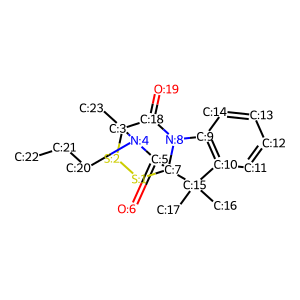

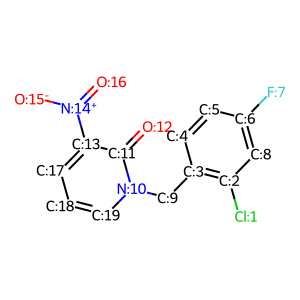

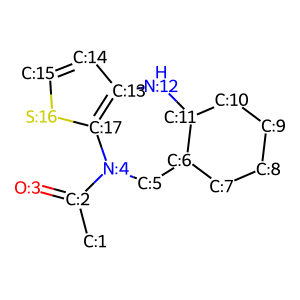

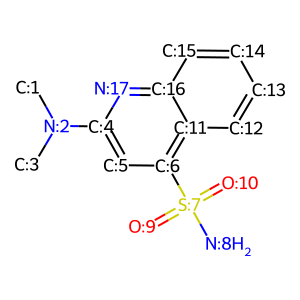

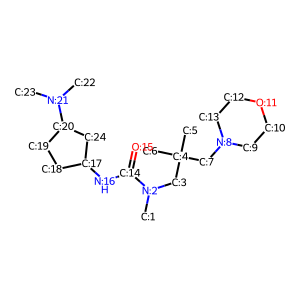

In [52]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

for i in range(5):
    m = Chem.MolFromSmiles(smis[i])
    img = Draw.MolToImage(m)
    display(img)